# 전이학습으로 소량 데이터 분류

In [3]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [4]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# DataSet 작성 

In [5]:
class ImageTransform():
    """
    화상 전처리 클래스, 훈려니,, 검증시의 동작이 다르다.
    
    Attributtes
    -----------
    resize : int
    mean : (R, G, B)
    std : (R, G, B)
    """
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),      # resize 기준 0.5에서 1.0사이즈로 랜덤하게 크기 조정
                transforms.RandomHorizontalFlip(), # 50% 확률로 반전 하거나 안하거나
                transforms.ToTensor(),             # 텐서로 변환
                transforms.Normalize(mean, std)    # 표준화
                ]),
            'val': transforms.Compose([
                transforms.Resize(resize),         # 리사이즈
                transforms.CenterCrop(resize),     # 이미지 중앙을 기준으로 resize x resize
                transforms.ToTensor(),             # 텐서로 변환
                transforms.Normalize(mean, std)    # 표준화
            ])
            }
        
    def __call__(self, img, phase='train'):
        
        return self.data_transform[phase](img)


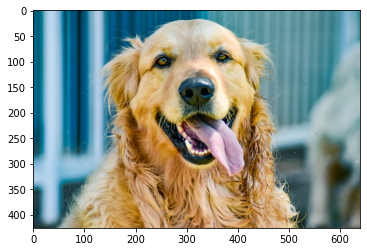

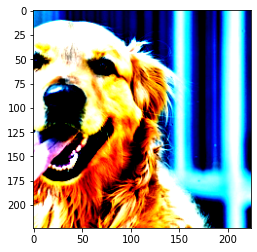

In [6]:
image_file_path = "./data/goldenretriever-3724972_640.jpg"
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [8]:
def make_datapath_list(phase="train"):
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")


train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/ants/382971067_0bfd33afe0.jpg',
 './data/hymenoptera_data/train/ants/2265824718_2c96f485da.jpg',
 './data/hymenoptera_data/train/ants/506249836_717b73f540.jpg',
 './data/hymenoptera_data/train/ants/6743948_2b8c096dda.jpg',
 './data/hymenoptera_data/train/ants/795000156_a9900a4a71.jpg',
 './data/hymenoptera_data/train/ants/424119020_6d57481dab.jpg',
 './data/hymenoptera_data/train/ants/506249802_207cd979b4.jpg',
 './data/hymenoptera_data/train/ants/938946700_ca1c669085.jpg',
 './data/hymenoptera_data/train/ants/841049277_b28e58ad05.jpg',
 './data/hymenoptera_data/train/ants/535522953_308353a07c.jpg',
 './data/hymenoptera_data/train/ants/957233405_25c1d1187b.jpg',
 './data/hymenoptera_data/train/ants/522415432_2218f34bf8.jpg',
 './data/hymenoptera_data/train/ants/178538489_bec7649292.jpg',
 './data/hymenoptera_data/train/ants/Nepenthes_rafflesiana_ant.jpg',
 './data/hymenoptera_data/train/ants/512164029_c0a66b8498.jpg',
 './data/hymenoptera_data/train/ants

In [9]:
class HymenopteraDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
        
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        
        return img_transformed, label

train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')


index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


# DataLoader 작성

In [10]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator) # 첫 번째 요소를 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0])


# 네트워크 모델 작성

In [11]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()
print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

/home/skang/Documents/Pytorch_tutorials/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/skang/Documents/Pytorch_tutorials/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


In [17]:
criterion = nn.CrossEntropyLoss()

In [19]:
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

for name, param in net.named_parameters():
    print(name, param)
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
        
print("----------")
print(params_to_update)

features.0.weight Parameter containing:
tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
          [-5.8312e-01,  3.5655e-01,  7.6566e-01],
          [-6.9022e-01, -4.8019e-02,  4.8409e-01]],

         [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
          [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
          [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],

         [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
          [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
          [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],


        [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
          [-4.2805e-01, -2.4349e-01,  2.4628e-01],
          [-2.5066e-01,  1.4177e-01, -5.4864e-03]],

         [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
          [-8.4127e-01, -3.5176e-01,  5.6398e-01],
          [-2.4194e-01,  5.1928e-01,  5.3915e-01]],

         [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
          [-4.7144e-01, -1.5503e-01,  3.4589e-01],
          [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],


        [[[ 1.7715e-01,  5

In [22]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [39]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('---------------')
        
        for phase in ['train', 'val']:
            if phase == "train":
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0

            if (epoch == 0) and (phase == 'train'): 
                continue
            
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                print(inputs.size())
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc : {epoch_acc:.4f}')


In [40]:
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
---------------


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 3, 224, 224])


 20%|██        | 1/5 [00:04<00:16,  4.25s/it]

torch.Size([32, 3, 224, 224])


 40%|████      | 2/5 [00:07<00:11,  3.95s/it]

torch.Size([32, 3, 224, 224])


 60%|██████    | 3/5 [00:11<00:07,  3.83s/it]

torch.Size([32, 3, 224, 224])


 80%|████████  | 4/5 [00:15<00:03,  3.77s/it]

torch.Size([25, 3, 224, 224])


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


val Loss: 0.7533 Acc : 0.4510
Epoch 2/2
---------------


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([32, 3, 224, 224])


 12%|█▎        | 1/8 [00:03<00:25,  3.62s/it]

torch.Size([32, 3, 224, 224])


 25%|██▌       | 2/8 [00:07<00:21,  3.58s/it]

torch.Size([32, 3, 224, 224])


 38%|███▊      | 3/8 [00:10<00:17,  3.53s/it]

torch.Size([32, 3, 224, 224])


 50%|█████     | 4/8 [00:14<00:14,  3.55s/it]

torch.Size([32, 3, 224, 224])


 62%|██████▎   | 5/8 [00:17<00:10,  3.57s/it]

torch.Size([32, 3, 224, 224])


 75%|███████▌  | 6/8 [00:21<00:07,  3.60s/it]

torch.Size([32, 3, 224, 224])


 88%|████████▊ | 7/8 [00:25<00:03,  3.58s/it]

torch.Size([19, 3, 224, 224])


100%|██████████| 8/8 [00:27<00:00,  3.40s/it]


train Loss: 0.5074 Acc : 0.7160


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 3, 224, 224])


 20%|██        | 1/5 [00:03<00:14,  3.53s/it]

torch.Size([32, 3, 224, 224])


 40%|████      | 2/5 [00:07<00:10,  3.57s/it]

torch.Size([32, 3, 224, 224])


 60%|██████    | 3/5 [00:10<00:07,  3.60s/it]

torch.Size([32, 3, 224, 224])


 80%|████████  | 4/5 [00:14<00:03,  3.59s/it]

torch.Size([25, 3, 224, 224])


100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

val Loss: 0.1797 Acc : 0.9608
